# Gambler's problem

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

/Users/gerardoduran/miniforge3/lib/python3.9/site-packages/jax/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
%config InlineBackend.figure_format = "retina"

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

## Value iteration

> Algorithm such that policy evaluation is stopped after just one sweep

The value iteration algorithm is given by following the following update rule:

$$
\begin{aligned}
    v_{k+1}(s) :&= \max_a \mathbb{E}[R_{t+1} + \gamma v_k(S_{t+1}) \vert S_t = s, A_t=a]\\
    &= \max_a\sum_{s', r}p(s', r \vert s, a)\left[r + \gamma v_k(s')\right]
\end{aligned}
$$

* For arbitrary $v_0$, the sequence $v_1, v_2, \ldots$ can be shown to converge to $v_*$ under the same conditions that guarantee the existence of $v_*$ using the policy iteration algorithm.

### Policy improvement
Compare the **value iteration** algorithm to the **policy iteration** algorithm which first tries to find the value function given a policy $\pi$. That is, we try to find $\forall s\in\mathcal{S}.v_\pi(s)$ such that

$$
    v_\pi(s) = \sum_{a} \pi(a\vert s) \sum_{s', r} p(s', r \vert s, a)\left[r + \gamma v_\pi(s')\right] \ \forall s '\in \mathcal{S}.
$$

After finding an optimal set of value functions $v_{\pi}(s)$, we *improve* the policy greedily instantiating a new policy $\pi'$ such that

$$
    \pi'(s) = \text{argmax}_a \sum_{s', r} p(s', r \vert s, a)[r + \gamma v_\pi(s)] \ \forall s \in \mathcal{S}.
$$

# The gambler's problem

* A gambler can make bets on a sequence of coins tosses. The probability of heads is given by $p_h$
* Before each toss the gambler decides how much to risk. If the coin lands heads, the gambler wins as many dollars as he has risked on that flip; if it is tail, he loses his stake.
* The game ends when the gambler wins by reading his goal of $100, or loses by running out of money.

## The setup

* The set of states is the gambler's capital: $\mathcal S = \{1, 2, \ldots, 99\}$
* The set of actions, given a state, are the stakes: $\mathcal{A}_{s} = \{0, 1, \ldots, \min(s, 100 - s)\}$

$$
\begin{aligned}
    \mathbb{P}(S_t=s', R_t=r \vert S_{t-1}=s, A_t=a) &= \mathbb{P}(S_t=s'\vert S_{t-1}=s, A_t=a)\mathbb{P}(R_t=r \vert S_{t}=s')\\
    &= \mathbb{P}(S_t=s'\vert S_{t-1}=s, A_t=a) \mathbb{1}(s' = 100)
\end{aligned}
$$

In [499]:
key = jax.random.PRNGKey(314)


p_heads = 0.4
p = jnp.array([p_heads, p_tails])
elements = jnp.array([0, 1])

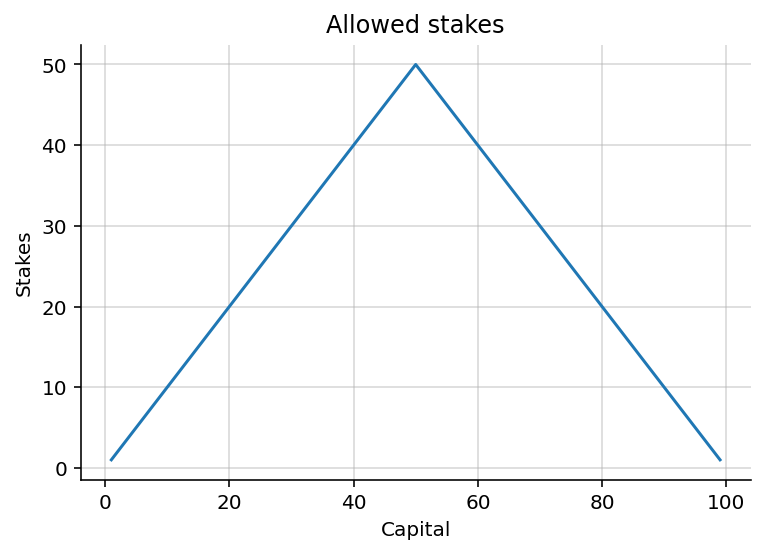

In [819]:
# We want to make sure we stay within the set of states 1,...,100
# to-do: play with the assymetry of the stakes. What happens if he can go "all in"?
#        note that in this case, we must change the states. Furthermore, the problem might
#        not be periodic. (We will need a discount factor)
capital = jnp.arange(1, 100)
plt.plot(capital, jnp.minimum(capital, 100 - capital))
plt.title("Allowed stakes")
plt.xlabel("Capital")
plt.ylabel("Stakes")
plt.grid(alpha=0.5)

In [1033]:
def p_state(capital, new_capital, stake, reward):
    proba = p_heads * (new_capital == capital + stake) + (1 - p_heads) * (new_capital == capital - stake)
    valid_reward = (reward == 0)
    valid_stakes = stake <= jnp.minimum(capital, 100 - capital)
    
    proba = proba * valid_stakes * valid_reward
    
    lower_p = (capital == 1) * (p_heads * (capital + stakes == new_capital) + (1 - p_heads) * (capital - stakes == new_capital))
    upper_p = (capital == 99) * ((capital + stakes == new_capital) * (reward == 1 ) + (capital - stakes == new_capital) * (reward == 0))
    
    return proba * (capital < 99) * (capital > 1) + lower_p + upper_p

In [1034]:
capital = 99
stakes = 1

p_state(capital, capital - stakes, stakes, 0), p_state(capital, capital + stakes, stakes, 0)

(DeviceArray(1., dtype=float32, weak_type=True),
 DeviceArray(0., dtype=float32, weak_type=True))

In [1025]:
capital = 99
jax.vmap(p_state, (None, 0, None, None))(capital, capital_range, 1, 0)

DeviceArray([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
             0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
             0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
             0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
             0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
             0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
             0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
             0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
             0. , 0. , 0.6, 0. , 0.4], dtype=float32)

In [1070]:
def p_state(capital, new_capital, stake, reward):
    proba = p_heads * (new_capital == capital + stake) + (1 - p_heads) * (new_capital == capital - stake)
    valid_reward = (reward == 0) * (new_capital < 100) + (reward == 1) * (new_capital == 100)
    valid_stakes = stake <= jnp.minimum(capital, 100 - capital)
    
    proba = proba * valid_stakes * valid_reward
    
    return proba * (capital < 100)

p_state = jax.vmap(p_state, (   0, None, None, None), out_axes=0)
p_state = jax.vmap(p_state, (None,    0, None, None), out_axes=1)
p_state = jax.vmap(p_state, (None, None,    0, None), out_axes=2)
p_state = jax.vmap(p_state, (None, None, None,    0), out_axes=3)

capital_range = jnp.arange(101)
new_capital_range = jnp.arange(101)
stakes_range = jnp.arange(51)
reward_range = jnp.arange(2)

p_grid = p_state(capital_range, new_capital_range, stakes_range, reward_range)

In [1060]:
value_function = jnp.zeros_like(capital_range)
it_sweeps = [1, 2, 3, 32]

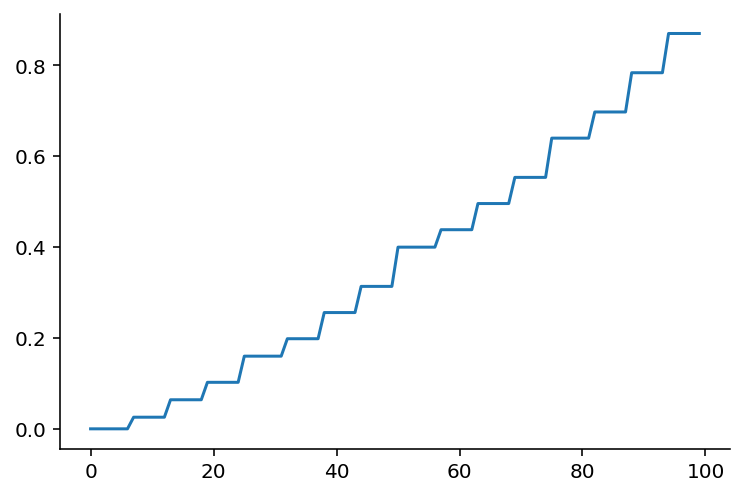

In [1103]:
reward_value_next = (reward_range[None, :] + value_function[:, None])
value_function = jnp.einsum("sjar,jr->as", p_grid, reward_value_next).max(axis=0)

plt.plot(value_function[:-1])

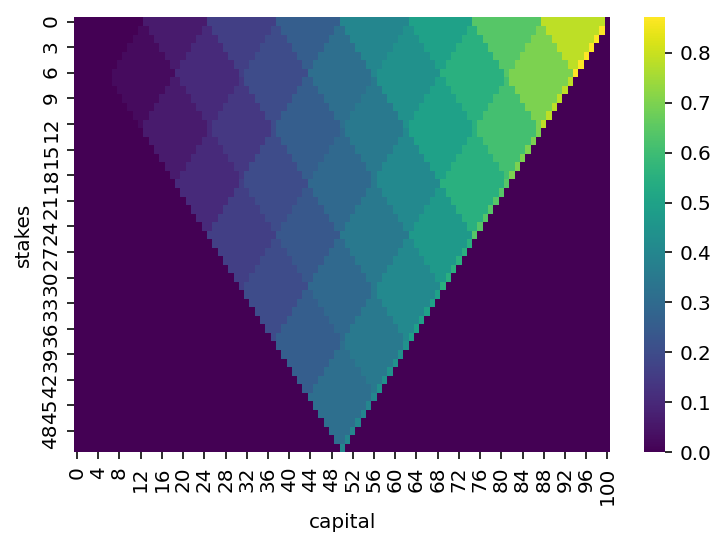

In [1104]:
sns.heatmap(jnp.einsum("ijar,jr->ai", p_grid, reward_value_next), cmap="viridis")
plt.xlabel("capital")
plt.ylabel("stakes");

In [354]:
n_elements = 101
value_function = jnp.zeros(n_elements)
it_sweeps = [1, 2, 3, 32]

sweep_hist = jnp.zeros((len(it_sweeps), n_elements))


for i in range(max(it_sweeps) + 1):
    reward_value_next = (reward_range[None, :] + value_function[:, None])
    value_function = jnp.einsum("ijar,jr->ai", p_grid, reward_value_next).max(axis=0)
    
    sweep_hist = sweep_hist.at[i].set(value_function)

(0.0, 1.0)

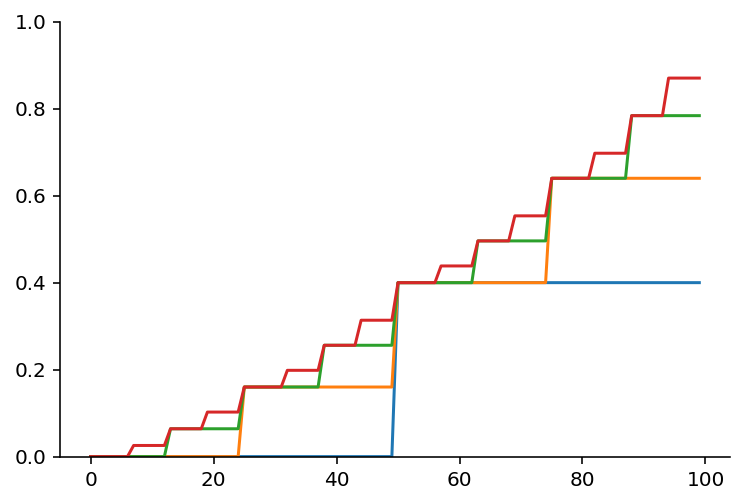

In [355]:
plt.plot(sweep_hist[:, :-1].T)
plt.ylim(0, 1)

In [144]:
# s, s', a, r
p_grid.shape

(101, 101, 51, 2)

In [103]:
# new_capital, stake
p_grid[0].shape

(101, 51)

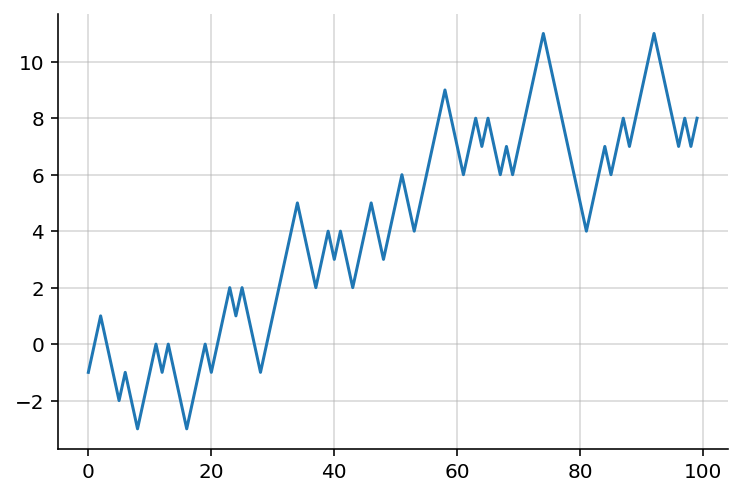

In [70]:
n_tosses = 100

sample = jax.random.choice(key, elements, shape=(n_tosses,), p=p)
plt.plot((2 * sample - 1).cumsum())
plt.grid(alpha=0.5)